# De-identification

```{admonition} Learning Objectives
After reading this chapter, you should be able to:
- Define the following concepts:
  - De-identification
  - Re-identification
  - Identifying information / personally identifying information
  - Linkage attacks
  - Aggregation and aggregate statistics
  - Differencing attacks
- Perform a linkage attack
- Perform a differencing attack
- Explain the limitations of de-identification techniques
- Explain the limitations of aggregate statistics
```

## Preliminary

Download the dataset by clicking [here](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_with_pii.csv) and placing them in the same directory as this notebook.

The dataset is based on census data. The personally identifiable information (PII) is made up.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
adult = pd.read_csv("adult_with_pii.csv")
adult.head()

,Name,DOB,SSN,Zip,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56
1,Brandise Tripony,6/7/1988,150-19-2766,61523,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35
2,Brenn McNeely,8/6/1991,725-59-9860,95668,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32
3,Dorry Poter,4/6/2009,659-57-4974,25503,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14
4,Dick Honnan,9/16/1951,220-93-3811,75387,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72


## De-identification

*De-identification* is the process of removing *identifying information* from a dataset. The term *de-identification* is sometimes used synonymously with the terms *anonymization* and *pseudonymization*.

Identifying information has no formal definition. It is usually understood to be information which would be used to identify us uniquely in the course of daily life - name, address, phone number, e-mail address, etc. As we will see later, it's *impossible* to formalize the concept of identifying information, because *all* information is identifying. The term *personally identifiable information (PII)* is often used synonymously with identifying information.

How do we de-identify information? Easy - we just remove the columns that contain identifying information!

In [6]:
adult_data = adult.copy().drop(columns=['Name', 'SSN'])
adult_pii = adult[['Name', 'SSN', 'DOB', 'Zip']]
adult_data.head(1)

,DOB,Zip,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age
0,9/7/1967,64152,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56


We'll save some of the identifying information for later, when we'll use it as *auxiliary data* to perform a *re-identification* attack.

## Linkage Attacks

Imagine we want to determine the income of a friend from our de-identified data. Names have been removed, but we happen to know some auxiliary information about our friend. Our friend's name is Karrie Trusslove, and we know Karrie's date of birth and zip code.

To perform a simple *linkage attack*, we look at the overlapping columns between the dataset we're trying to attack, and the auxiliary data we know. In this case, both datasets have dates of birth and zip codes. We look for rows in the dataset we're attacking with dates of birth and zip codes that match Karrie's date of birth and zip code. In databases, this is called a *join* of two tables, and we can do it in Pandas using `merge`. If there is only one such row, we've found Karrie's row in the dataset we're attacking.

In [7]:
karries_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove']
pd.merge(karries_row, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])

,Name,SSN,DOB,Zip,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56


Indeed, there is only one row that matches. We have used auxiliary data to re-identify an individual in a de-identified dataset, and we're able to infer that Karrie's income is less than $50k.

### How Hard is it to Re-Identify Karrie?

This scenario is made up, but linkage attacks are surprisingly easy to perform in practice. How easy? It turns out that in many cases, just one data point is sufficient to pinpoint a row!

In [8]:
pd.merge(karries_row, adult_data, left_on=['Zip'], right_on=['Zip'])

,Name,SSN,DOB_x,Zip,DOB_y,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,9/7/1967,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56


So ZIP code is sufficient **by itself** to allow us to re-identify Karrie. What about date of birth?

In [9]:
pd.merge(karries_row, adult_data, left_on=['DOB'], right_on=['DOB'])

,Name,SSN,DOB,Zip_x,Zip_y,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,64152,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56
1,Karrie Trusslove,732-14-6110,9/7/1967,64152,67306,Private,11th,Widowed,Farming-fishing,Unmarried,White,Female,40,United-States,<=50K,56
2,Karrie Trusslove,732-14-6110,9/7/1967,64152,62254,Self-emp-not-inc,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,>50K,56


This time, there are three rows returned - and we don't know which one is the real Karrie. But we've still learned a lot!

- We know that there's a 2/3 chance that Karrie's income is less than $50k
- We can look at the differences between the rows to determine what additional auxiliary information would *help* us to distinguish them (e.g. sex, occupation, marital status)

### Is Karrie Special?

How hard is it to re-identify others in the dataset? Is Karrie especially easy or especially difficult to re-identify? A good way to gauge the effectiveness of this type of attack is to look at how "selective" certain pieces of data are - how good they are at narrowing down the set of potential rows which may belong to the target individual. For example, is it common for birthdates to occur more than once?

We'd like to get an idea of how many dates of birth are likely to be useful in performing an attack, which we can do by looking at how common "unique" dates of birth are in the dataset. The histogram below shows that *the vast majority* of dates of birth occur 1, 2, or 3 times in the dataset, and *no date of birth* occurs more than 8 times. This means that date of birth is fairly *selective* - it's effective in narrowing down the possible records for an individual.

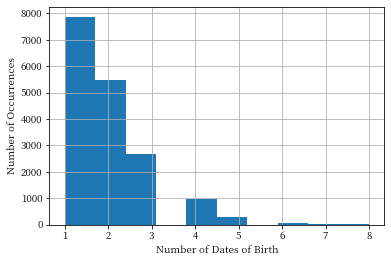

In [10]:
adult_pii['DOB'].value_counts() .hist()
plt.xlabel('Number of Dates of Birth')
plt.ylabel('Number of Occurrences');

We can do the same thing with ZIP codes, and the results are even worse - ZIP code happens to be *very* selective in this dataset. Nearly all the ZIP codes occur only once.

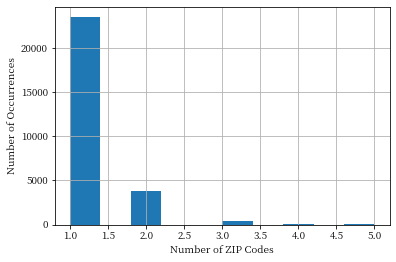

In [11]:
adult_pii['Zip'].value_counts().hist()
plt.xlabel('Number of ZIP Codes')
plt.ylabel('Number of Occurrences');

### How Many People can we Re-Identify?

In this dataset, how many people can we re-identify uniquely? We can use our auxiliary information to find out! First, let's see what happens with just dates of birth. We want to know how many *possible identities* are returned for each data record in the dataset. The following histogram shows the number of records with each number of possible identities. The results show that we can uniquely identify almost 7,000 of the data records (out of about 32,000), and an additional 10,000 data records are narrowed down to two possible identities.

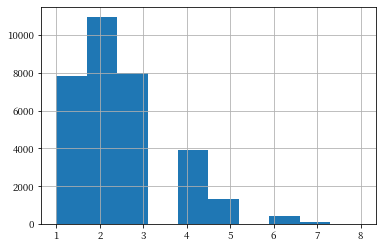

In [12]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB'], right_on=['DOB'])
attack['Name'].value_counts().hist();

So it's not possible to re-identify a majority of individuals using *just* date of birth. What if we collect more information, to narrow things down further? If we use both date of birth and ZIP, we're able to do much better. In fact, we're able to uniquely re-identify basically the whole dataset.

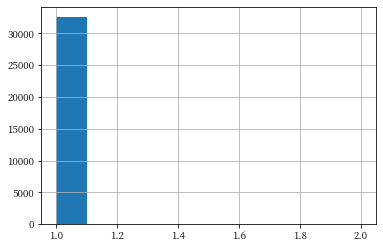

In [13]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])
attack['Name'].value_counts().hist();

When we use both pieces of information, we can re-identify **essentially everyone**. This is a surprising result, since we generally assume that many people share the same birthday, and many people live in the same ZIP code. It turns out that the *combination* of these factors is **extremely** selective. According to Latanya Sweeney's work {cite}`identifiability`, 87% of people in the US can be uniquely re-identified by the combination of date of birth, gender, and ZIP code.

Let's just check that we've actually re-identified *everyone*, by printing out the number of possible data records for each identity:

In [14]:
attack['Name'].value_counts().head()

Antonin Chittem    2
Barnabe Haime      2
Gwenny Penley      1
Marvin Daubney     1
Ursola Walasik     1
Name: Name, dtype: int64

Looks like we missed two people! In other words, in this dataset, only **two people** share a combination of ZIP code and date of birth.

## Aggregation

Another way to prevent the release of private information is to release only *aggregate* data.

In [15]:
adult['Age'].mean()

41.772181444058845

### Problem of Small Groups

In many cases, aggregate statistics are broken down into smaller groups. For example, we might want to know the average age of people with a particular education level.

In [23]:
adult[['Education', 'Age']].groupby('Education', as_index=False).mean().head(3)

,Education,Age
0,10th,42.032154
1,11th,42.057021
2,12th,41.879908


Aggregation is supposed to improve privacy because it's hard to identify the contribution of a particular individual to the aggregate statistic. But what if we aggregate over a group with just *one person* in it? In that case, the aggregate statistic reveals one person's age *exactly*, and provides no privacy protection at all! In our dataset, most individuals have a unique ZIP code - so if we compute the average age by ZIP code, then most of the "averages" actually reveal an individual's exact age.

In [24]:
adult[['Zip', 'Age']].groupby('Zip', as_index=False).mean().head()

,Zip,Age
0,4,72.0
1,12,46.0
2,16,38.0
3,17,31.0
4,18,40.0


The US Census Bureau, for example, releases aggregate statistics at the [*block level*](https://www.census.gov/newsroom/blogs/random-samplings/2011/07/what-are-census-blocks.html). Some census blocks have large populations, but some have a population of zero! The situation above, where small groups prevent aggregation from hiding information about individuals, turns out to be quite common.

How big a group is "big enough" for aggregate statistics to help? It's hard to say - it depends on the data and on the attack - so it's challenging to build confidence that aggregate statistics are really privacy-preserving. However, even very large groups do not make aggregation completely robust against attacks, as we will see next.

### Differencing Attacks

The problems with aggregation get even worse when you release multiple aggregate statistics over the same data. For example, consider the following two summation queries over large groups in our dataset (the first over the whole dataset, and the second over all records except one):

In [19]:
adult['Age'].sum()

1360144

In [20]:
adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

1360088

If we know both answers, we can simply take the difference and determine Karrie's age completely! This kind of attack can proceed even if the aggregate statistics are over *very large groups*.

In [22]:
adult['Age'].sum() - adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

56

This is a recurring theme.

- Releasing *data* that is useful makes ensuring *privacy* very difficult
- Distinguishing between *malicious* and *non-malicious* queries is not possible

```{admonition} Summary
- A *linkage attack* involves combining *auxiliary data* with *de-identified data* to *re-identify* individuals.
- In the simplest case, a linkage attack can be performed via a *join* of two tables containing these datasets.
- Simple linking attacks are surprisingly effective:
  - Just a single data point is sufficient to narrow things down to a few records
  - The narrowed-down set of records helps suggest additional auxiliary data which might be helpful
  - Two data points are often good enough to re-identify a huge fraction of the population in a particular dataset
  - Three data points (gender, ZIP code, date of birth) uniquely identify 87% of people in the US
```  